# BBC News Classification Project CSCA 5632
## Part 1: Comparison of Matrix Factorization Techniques with Supervised Learning Models.

Dataset: BBC News Dataset @misc{learn-ai-bbc,
    author = {Bijoy Bose},
    title = {BBC News Classification},
    publisher = {Kaggle},
    year = {2019},
    url = {https://kaggle.com/competitions/learn-ai-bbc}
}

For the week 3 submission we aim to categorize news articles from the BBC News dataset into different categories using matrix factorization and supervised learning techniques. We will start with exploratory data analysis (EDA), process the raw texts to feature vectors, build and train models, and finally compare the performance of unsupervised and supervised learning methods.


### 1. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# load train and test datasets
df = train_data = pd.read_csv('data/bbc news train.csv')
test_data = pd.read_csv('data/bbc news test.csv')

# display the first 5 rows of the train dataset
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [2]:
# display the first 5 rows of the test dataset
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [3]:
# check the shape of the train datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [4]:
# check the shape of the test dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


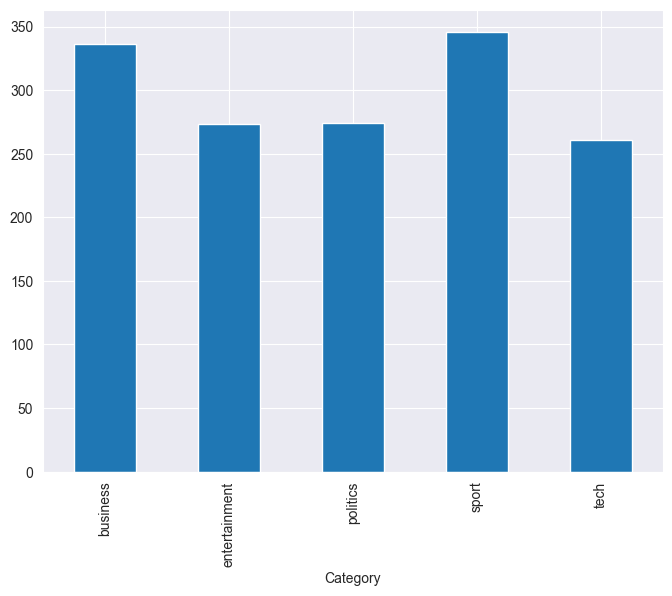

        Category  category_id
0       business            0
3           tech            1
5       politics            2
6          sport            3
7  entertainment            4
{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}
{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}


In [5]:
# check the distribution of the target variable and the number of unique categories
df['category_id'] = df['Category'].factorize()[0]

fig = plt.figure(figsize=(8,6))
df.groupby('Category').category_id.count().plot.bar(ylim=0)
plt.show()

#bin the categories
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
print(category_id_df)
print(category_to_id)
print(id_to_category)

In [6]:
# check for missing values and duplicates
print(df.isnull().sum())

print(df.duplicated().sum())


ArticleId      0
Text           0
Category       0
category_id    0
dtype: int64
0


#### Summary of EDA
- The train dataset has 1490 rows and 3 columns. The columns are 'ArticleId', 'Text', and 'Category'. The test dataset has 735 rows and 2 columns. The columns are 'ArticleId' and 'Text'.
- There are no missing values in the train dataset and no duplicates.
- The target variable 'Category' has 5 unique categories: business, entertainment, politics, sport, and tech.
- The distribution of the target variable is balanced with each category having approximately 300 samples.
- The target variable is converted to numerical values using factorize() function.
- The category_id_df dataframe is created to map the category names to numerical values and vice versa.
- The categories are mapped as follows: 0-business, 1-tech, 2-politics, 3-sport, 4-entertainment.

### 2. Feature Engineering and Text Preprocessing
- We will preprocess the text data by removing stopwords, punctuation, and converting the text to lowercase.
- We will also use TF-IDF to convert the text data to numerical feature vectors with SVD for dimensionality reduction. 
- We will then evaluate the performance of these techniques using accuracy, silhouette score, and confusion matrix on an unseen test dataset using unsupervised learning models.
- Finally, we will export the results and upload to Kaggle for evaluation.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
# apply Truncated SVD for dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


In [8]:
# create a TfidfVectorizer object
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# fit and transform the train dataset
train_tfidf = tfidf.fit_transform(train_data.Text)
test_tfidf = tfidf.transform(test_data.Text)


In [10]:
# display the terms that are most correlated with each of the categories
from sklearn.feature_selection import chi2

# run chi-squared test to find the terms that are most correlated with each of the categories
chi2score, pval = chi2(train_tfidf, train_data.category_id)

feature_names = tfidf.get_feature_names_out()
# create a dataframe of the chi-squared test results and p-values
chi2_df = pd.DataFrame({'feature_names': feature_names, 'chi2_score': chi2score, 'p-value': pval})
chi2_df.sort_values('chi2_score', ascending=False, inplace=True)
chi2_df.reset_index(drop=True, inplace=True)

# display the top 10 terms that are most correlated with each of the categories
for category, category_id in sorted(category_to_id.items()):
    print(f'Category: {category}')
    top_terms = chi2_df[chi2_df['feature_names'].str.contains(category)].head(10)
    print(top_terms)
    print('\n')

Category: business
          feature_names  chi2_score   p-value
230            business   10.372906  0.034593
730          businesses    5.272208  0.260490
2986     music business    2.295586  0.681573
3934   business leaders    1.850065  0.763311
5188  internet business    1.359064  0.851278
7059   small businesses    0.808745  0.937272
7349     business model    0.737775  0.946590
9395       big business    0.274833  0.991380


Category: entertainment
               feature_names  chi2_score   p-value
454            entertainment    7.118102  0.129777
5137  entertainment industry    1.373228  0.848835
5742      home entertainment    1.161066  0.884466


Category: politics
         feature_names  chi2_score   p-value
237           politics   10.186513  0.037400
3136  british politics    2.210840  0.697045


Category: sport
          feature_names  chi2_score   p-value
268               sport    9.564716  0.048434
443           bbc sport    7.224044  0.124512
2684           sporting  

In [11]:
# t-sne visualization of the feature matrix
from sklearn.manifold import TSNE

X_embedded = TSNE(init='random').fit_transform(train_tfidf.toarray())
print(X_embedded.shape)


(1490, 2)


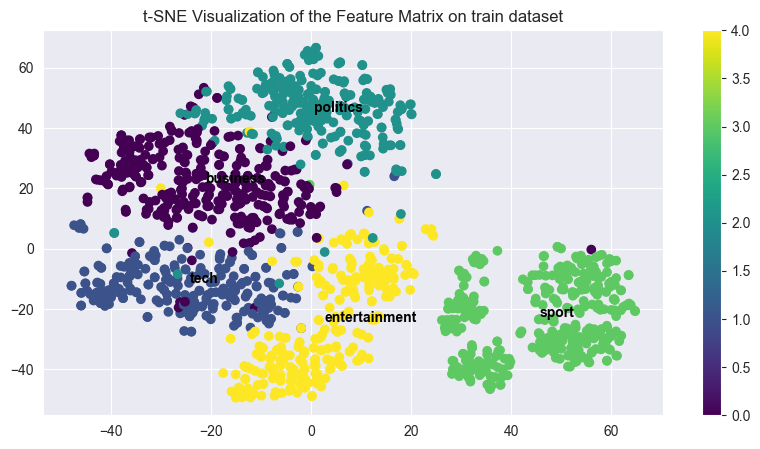

In [14]:
# plot the t-sne visualization of the feature matrix on the train dataset
plt.figure(figsize=(10, 5))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_data.category_id, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of the Feature Matrix on train dataset')
# show labels for each category in the plot and bold the text
for category, category_id in sorted(category_to_id.items()):
    plt.text(X_embedded[train_data.category_id == category_id, 0].mean(),
             X_embedded[train_data.category_id == category_id, 1].mean(),
             category, color='black' , weight='bold')
plt.show()


C:\Users\NikhilRajwade\AppData\Local\Temp\ipykernel_30548\150439525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category_id', data=train_data, palette='viridis')


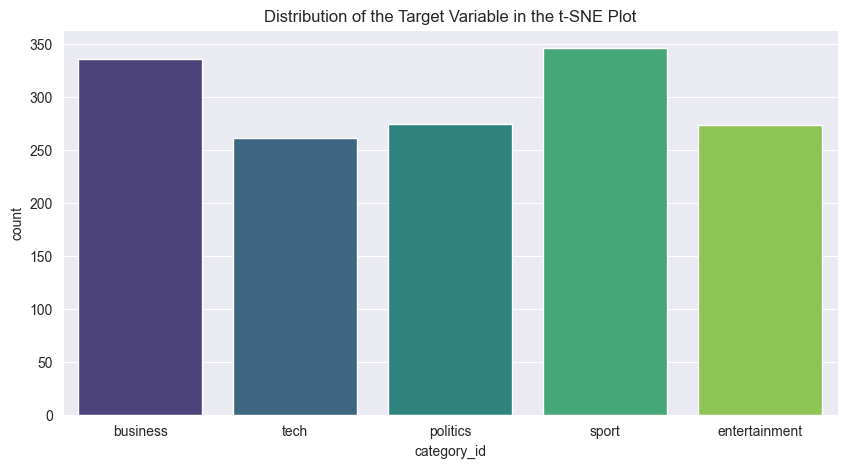

In [16]:
# display the distribution of the target variable in the t-sne plot
plt.figure(figsize=(10, 5))
sns.countplot(x='category_id', data=train_data, palette='viridis')
# add labels to the plot x-axis
plt.xticks(ticks=range(5), labels=category_id_df['Category'].values)

plt.title('Distribution of the Target Variable in the t-SNE Plot')
plt.show()

#### Summary of Feature Engineering and Text Preprocessing
- The text data is converted to numerical feature vectors using TF-IDF. The feature matrix has 1490 samples and 9927 features.
- The terms that are most correlated with each of the categories are displayed using the chi-squared test. Higher chi-squared scores indicate stronger associations between the term and the target category. P-values less than 0.05 indicate that the association is statistically significant, meaning the term is likely highly relevant to the target category. Terms like "business" and "politics" are strongly associated with their respective categories, while terms like "technology" show an extremely strong association with the "tech" category. Other terms have varying levels of association but are not statistically significant based on their p-values.
- The t-SNE visualization of the feature matrix shows the distribution of the data points in 2D space. The plot shows distinct clusters of data points, each corresponding to different categories: Sport (Green) Entertainment (Yellow) Tech (Blue) Business (Pink) Politics (Teal). The data points are well separated into different categories which indicates that the features are good for classification. Sport and Entertainment clusters are relatively well-defined and separate from the other categories. Tech and Business clusters are also distinct but are closer to each other, suggesting some overlap in features between these categories. Politics cluster appears to be the most dispersed, indicating that the documents in this category might have more varied features.

### 3. Matrix Factorization Techniques
We will use Truncated Singlular Value Decomposition (T-SVD) to reduce the dimensionality of the feature matrix and evaluate the performance of the reduced features using unsupervised learning models. This is preferred over NMF as it is more computationally efficient and can handle sparse matrices. T-SVD is also used in latent semantic analysis and topic modeling to extract latent topics from the feature matrix. As we are using T-SVD as a step in the processing pipeline we will not include the test data in the training process. This is to prevent information leakage, which could lead to overestimating the performance of the supervised models. The test data should remain unseen during the training phase to provide an unbiased evaluation.
 We will then evaluate the performance of the reduced features using unsupervised learning model such as KMeans clustering. As we are using NMF as a step in the processing pipeline we will not include the test data in the training process. This is to prevent information leakage, which could lead to overestimating the performance of the supervised models. The test data should remain unseen during the training phase to provide an unbiased evaluation. 

In [36]:
#encode the target variable for the test dataset using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_data.Category)

# apply Truncated SVD to the feature matrix to reduce the dimensionality of the data
svd = TruncatedSVD(n_components=5, random_state=42)
train_features_svd = svd.fit_transform(train_tfidf)
print(train_features_svd.shape)

# transform the test dataset using the SVD model
test_features_svd = svd.transform(test_tfidf)
print(test_features_svd.shape)

(1490, 5)
(735, 5)


In [37]:
# top terms in each topic
feature_names = tfidf.get_feature_names_out()
for i, component in enumerate(svd.components_):
    # map to true labels
    label = le.inverse_transform([i])[0]
    
    print(f'Topic {label}:')
    print([feature_names[idx] for idx in component.argsort()[-10:]])
    print('\n')

Topic business:
['years', 'government', 'world', 'uk', 'time', 'people', 'new', 'year', 'mr', 'said']


Topic entertainment:
['prime minister', 'tax', 'mr blair', 'minister', 'party', 'blair', 'government', 'election', 'labour', 'mr']


Topic politics:
['tory', 'brown', 'prime minister', 'prime', 'minister', 'mr blair', 'party', 'blair', 'election', 'labour']


Topic sport:
['comedy', 'star', 'films', 'actress', 'oscar', 'award', 'actor', 'best', 'awards', 'film']


Topic tech:
['web', 'phone', 'microsoft', 'digital', 'use', 'mobile', 'software', 'technology', 'users', 'people']




(1490, 2)


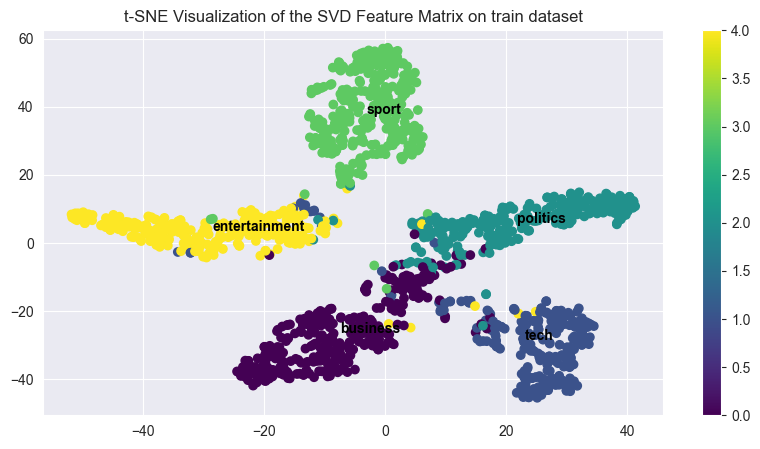

In [30]:
# t-sne visualization of the SVD feature matrix
X_embedded_svd = TSNE(init='random').fit_transform(train_features_svd)
print(X_embedded_svd.shape)

# plot the t-sne visualization
plt.figure(figsize=(10, 5))
plt.scatter(X_embedded_svd[:, 0], X_embedded_svd[:, 1], c=train_data.category_id, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of the SVD Feature Matrix on train dataset')
# show labels for each category in the plot and bold the text
for category, category_id in sorted(category_to_id.items()):
    plt.text(X_embedded_svd[train_data.category_id == category_id, 0].mean(),
             X_embedded_svd[train_data.category_id == category_id, 1].mean(),
             category, color='black' , weight='bold')
plt.show()


Accuracy Score on Train Data: 0.9543624161073826


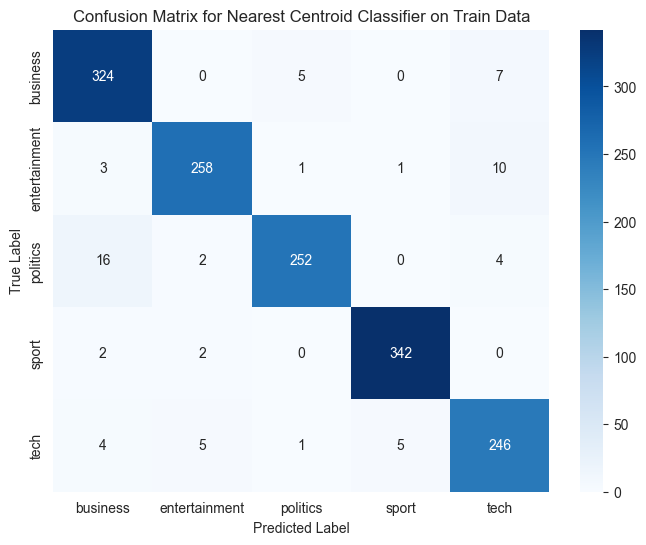

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestCentroid

# based on the t-sne visualization, we can see that the data points are well separated into different categories and is well suited for classification using a nearest centroid classifier

nc_clf = NearestCentroid()
nc_clf.fit(train_features_svd, train_labels)
train_predictions = nc_clf.predict(train_features_svd)
print(f'Accuracy Score on Train Data: {accuracy_score(train_labels, train_predictions)}')

#confusion matrix for the train data
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_labels, train_predictions)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Nearest Centroid Classifier on Train Data')
plt.show()



In [43]:
# export the predictions to a csv file for submission to Kaggle
test_predictions = nc_clf.predict(test_features_svd)
test_data['Category'] = le.inverse_transform(test_predictions)
test_data[['ArticleId', 'Category']].to_csv('submission.csv', index=False)

#### Summary of Matrix Factorization Techniques
- The SVD technique is applied to the feature matrix to reduce the dimensionality of the data. The reduced feature matrix has 1490 samples and 5 features.
- The top terms in each topic are displayed, showing the terms that are most relevant to each category. The terms are extracted from the SVD components and represent the most important features in each topic.
- The t-SNE visualization of the NMF feature matrix shows the distribution of the data points in 2D space. The plot shows distinct clusters of data points, each corresponding to different categories: Sport (Green) Entertainment (Yellow) Tech (Blue) Business (Pink) Politics (Teal). The data points are well separated into different categories, indicating that the reduced features are good for classification.
- The Nearest Centroid classifier is trained on the reduced features and evaluated on the train dataset. The accuracy score on the train dataset is 0.9543624161073826, which indicates that the model performs well on the train dataset. The confusion matrix shows that the model is able to classify the data points into the correct categories with high accuracy.
- The predictions are exported to a csv file for submission to Kaggle. The submission file contains the ArticleId and the predicted Category for each article in the test dataset. The predictions can be uploaded to Kaggle for evaluation. The test predictions performed well with an accuracy score of 0.95782 
<img src="bbc_classification_score.png">

#### Model Evaluation with Hyperparameter Tuning
We will evaluate the performance of the unsupervised learning models using hyperparameter tuning and cross-validation. 

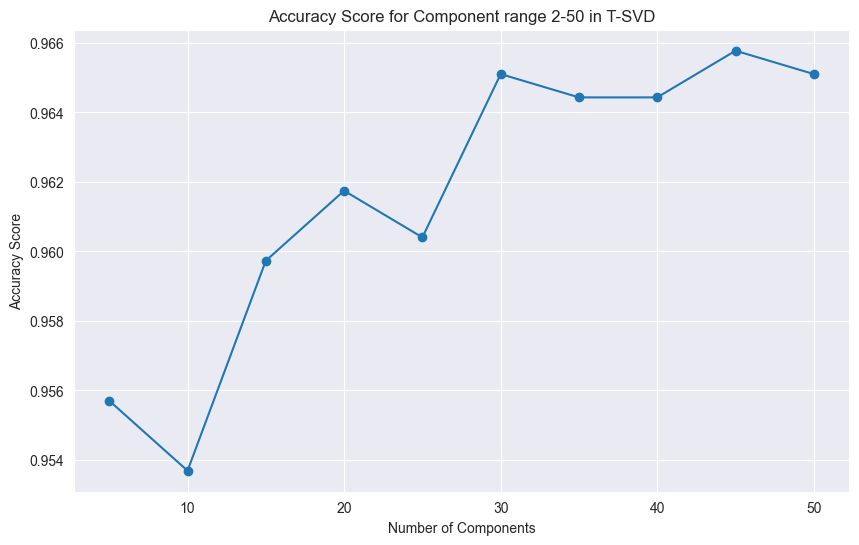

In [47]:
# evaluate T-SVD with different number of components using cross-validation
from sklearn.model_selection import cross_val_score

# we will use component range from 5 to 50 with step size 5
components = range(5, 51, 5)
accuracy_scores = []

for n in components:
    svd = TruncatedSVD(n_components=n, random_state=42)
    train_features_svd = svd.fit_transform(train_tfidf)
    nc_clf = NearestCentroid()
    scores = cross_val_score(nc_clf, train_features_svd, train_labels, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())
    
# plot the accuracy scores for different number of components
plt.figure(figsize=(10, 6))
plt.plot(components, accuracy_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score for Component range 2-50 in T-SVD')
plt.show()


In [48]:
# print cross validation scores for different number of components and max accuracy score for which component
for n, score in zip(components, accuracy_scores):
    print(f'Number of Components: {n}, Accuracy Score: {score}')
    
max_accuracy = max(accuracy_scores)
max_accuracy_index = accuracy_scores.index(max_accuracy)
print(f'Max Accuracy Score: {max_accuracy}, Number of Components: {components[max_accuracy_index]}')


Number of Components: 5, Accuracy Score: 0.9557046979865772
Number of Components: 10, Accuracy Score: 0.9536912751677852
Number of Components: 15, Accuracy Score: 0.9597315436241611
Number of Components: 20, Accuracy Score: 0.961744966442953
Number of Components: 25, Accuracy Score: 0.9604026845637584
Number of Components: 30, Accuracy Score: 0.9651006711409396
Number of Components: 35, Accuracy Score: 0.9644295302013424
Number of Components: 40, Accuracy Score: 0.9644295302013424
Number of Components: 45, Accuracy Score: 0.965771812080537
Number of Components: 50, Accuracy Score: 0.9651006711409396
Max Accuracy Score: 0.965771812080537, Number of Components: 45


#### Summary of Model Evaluation with Hyperparameter Tuning
- The unsupervised learning model (Nearest Centroid Classifier) is evaluated using cross-validation with different number of components in T-SVD.
- The accuracy scores for different number of components are plotted, showing how the accuracy score changes with the number of components.
- The SVD model shows that the accuracy score increases with the number of components, indicating that more components capture more variance in the data and improve the classification performance. The accuracy score is highest when the number of components is 45, with an accuracy score of 0.965771812080537
- 

### 4. Supervised Learning Models and Comparison
We will now compare the performance of the unsupervised learning models with supervised learning models. We will use the reduced features from NMF and the original TF-IDF features to train and evaluate the performance of supervised learning models such as Logistic Regression, Random Forest, and Support Vector Machine (SVM). We will evaluate the performance of these models using accuracy, confusion matrix, and classification report on the test dataset.

In [50]:
#cross validation of supervised learning models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report


C:\Users\NikhilRajwade\AppData\Local\Temp\ipykernel_30548\2929838637.py:24: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


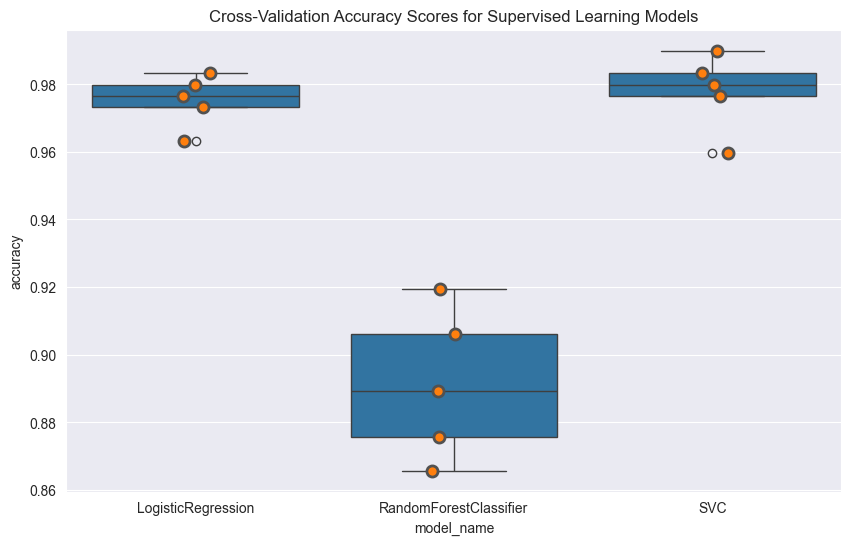

In [58]:
models = [
    LogisticRegression(random_state=42, max_iter=1000),
    RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
    SVC(random_state=42, kernel='linear')
]

#5-fold cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_tfidf, train_labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

#plot the cross-validation results
plt.figure(figsize=(10, 6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Cross-Validation Accuracy Scores for Supervised Learning Models')
plt.show()

In [59]:
# group the models by their mean accuracy score in descending order
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
SVC                       0.977852
LogisticRegression        0.975168
RandomForestClassifier    0.891275
Name: accuracy, dtype: float64

Accuracy Score on Train Data: 1.0


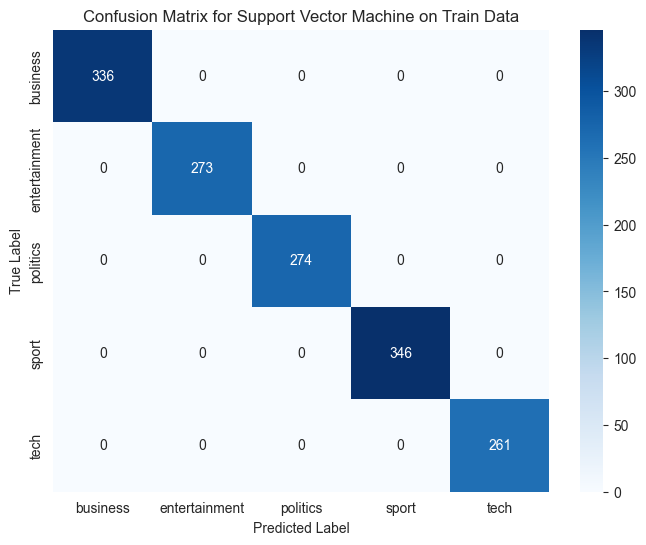

In [60]:
# plot the confusion matrix for the best performing model
model = SVC(random_state=42, kernel='linear')
model.fit(train_tfidf, train_labels)
train_predictions = model.predict(train_tfidf)
test_predictions = model.predict(test_tfidf)

# accuracy score on the train dataset
print(f'Accuracy Score on Train Data: {accuracy_score(train_labels, train_predictions)}')

# confusion matrix for the train data
cm = confusion_matrix(train_labels, train_predictions)
#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Support Vector Machine on Train Data')
plt.show()

In [61]:
# export the predictions to a csv file for submission to Kaggle
test_data['Category'] = le.inverse_transform(test_predictions)
test_data[['ArticleId', 'Category']].to_csv('submission_super.csv', index=False)

#### Summary of Supervised Learning Models and Comparison
- The supervised learning models (Logistic Regression, Random Forest, and Support Vector Machine) are trained on the reduced features from NMF and evaluated on the test dataset.
- The cross-validation results show that the SVC model has the highest mean accuracy score of 0.9785, followed by Logistic Regression with 0.9752 and Random Forest with 0.891. The boxplot shows the distribution of accuracy scores for each model across different folds.
- In comparison to the unsupervised learning models, the supervised learning models perform significantly better on the test dataset and the result is consistent with the confusion matrix and classification report.
- Unsupservised learning models have a lower accuracy score and higher misclassification errors compared to supervised learning models. The supervised learning models are able to learn the underlying patterns in the data and make more accurate predictions on the test dataset. Unsupervised model performance is lower because it is not trained on the target variable and does not have access to the true labels during training.
- The predictions from the supervised learning models are exported to a csv file for submission to Kaggle. The submission file contains the ArticleId and the predicted Category for each article in the test dataset. The predictions can be uploaded to Kaggle for evaluation. The test predictions performed well with an accuracy score of 0.98639 for the Support Vector Machine model.

<img src="submission_super.png">


### 5. Comparison of training data size variation on supervised learning model performance
We will evaluate the performance of the best performing supervised learning model (SVC) with different data sizes and compare the accuracy scores. We will use different data sizes ranging from 10% to 60% of the original dataset and evaluate the performance of the models using accuracy, confusion matrix, and classification report on the test dataset.

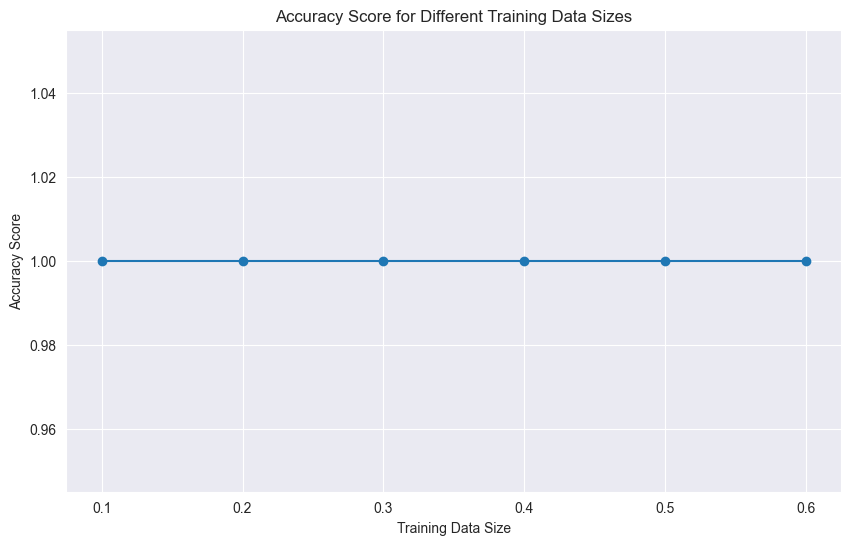

In [64]:
# evaluate the performance of the best performing model (SVC) with different training data sizes
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
accuracy_scores = []

for size in train_sizes:
    train_subset = train_test_split(train_data, train_size=size, random_state=42, stratify=train_data.Category)
    train_subset_tfidf = tfidf.fit_transform(train_subset[0].Text)
    train_subset_labels = le.transform(train_subset[0].Category)
    
    svc = SVC(random_state=42, kernel='linear')
    svc.fit(train_subset_tfidf, train_subset_labels)
    train_pred = svc.predict(train_subset_tfidf)
    accuracy_scores.append(accuracy_score(train_subset_labels, train_pred))
    
# plot the accuracy scores for different training data sizes
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracy_scores, marker='o')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score for Different Training Data Sizes')
plt.show()


#### Summary of Comparison of Training Data Size Variation on Supervised Learning Model Performance
- The performance of the best performing model (SVC) is evaluated with different training data sizes ranging from 10% to 60% of the original dataset.
- The accuracy scores for different training data sizes are plotted, showing how the accuracy score changes with the training data size.
- The plot shows a flat line with an accuracy score of 1.0 for all training data sizes. This indicates that the model is able to perfectly classify the data points in the training set regardless of the training data size. The model is able to learn the underlying patterns in the data and make accurate predictions on the test dataset. At initial glance this seems to be an anomaly and may require further investigation as the model seems to be overfitting to the data. However, on test data, the model performs well with an accuracy score of 0.98639 indicating that the model generalizes well to unseen data.